# **Loading and Preprocessing the Dataset:**

In [1]:
# Load the dataset
import pandas as pd

df = pd.read_csv('eng_-french.csv')
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [2]:
# The shape
df.shape

(175621, 2)

In [3]:
# Check for NaNs
print(df.isna().sum())

English words/sentences    0
French words/sentences     0
dtype: int64


In [4]:
# Check for duplicates
df.duplicated().sum()

0

In [5]:
# Lowercasing and Separation of English and French datasets
from functions import lower_text
eng_sentences = list(df['English words/sentences'].apply(lower_text))
fr_sentences = list(df['French words/sentences'].apply(lower_text))

In [6]:
eng_sentences[:5]

['hi.', 'run!', 'run!', 'who?', 'wow!']

In [7]:
fr_sentences[:5]

['salut!', 'cours!', 'courez!', 'qui ?', 'ça alors!']

In [8]:
# Count the english words ...
from collections import Counter

eng_word_counter = Counter([word for sentence in eng_sentences for word in sentence.split()])
print("Total count of English words:", sum(eng_word_counter.values()))
print("Count of distinct English words:", len(eng_word_counter))
print("10 most common English words:", list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 25622
10 most common English words: ('i', 'you', 'to', 'the', 'a', 'is', 'tom', 'he', 'of', 'do')


In [9]:
# Count the french words ...
fr_word_counter = Counter([word for sentence in fr_sentences for word in sentence.split()])
print("Total count of French words:", sum(fr_word_counter.values()))
print("Count of distinct French words:", len(fr_word_counter))
print("10 most common French words:", list(zip(*fr_word_counter.most_common(10)))[0])

Total count of French words: 1171716
Count of distinct French words: 44323
10 most common French words: ('je', 'de', 'pas', 'que', '?', 'à', 'ne', 'le', 'la', 'vous')


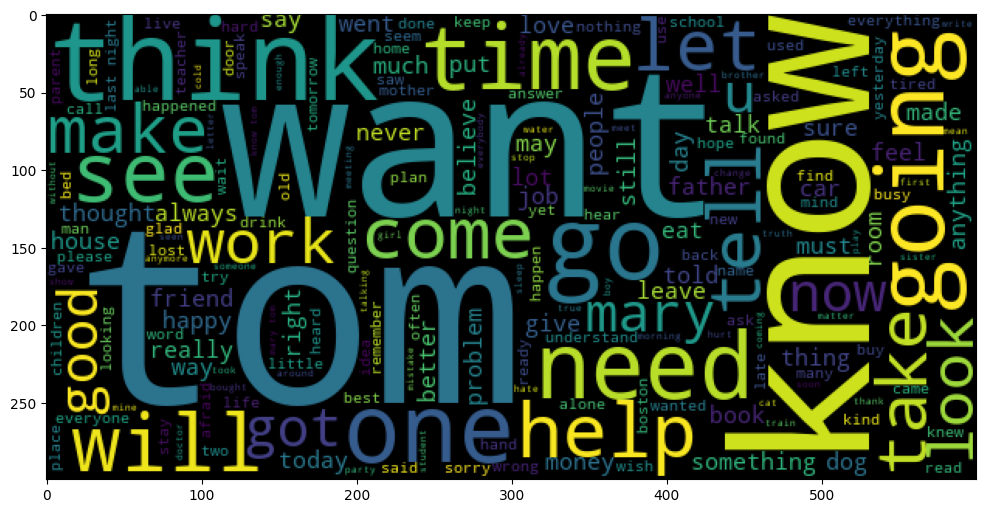

In [10]:
# The word cloud visualization of english words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
wc = WordCloud(width=600, height=300).generate(' '.join(eng_sentences))
plt.imshow(wc)
plt.show()

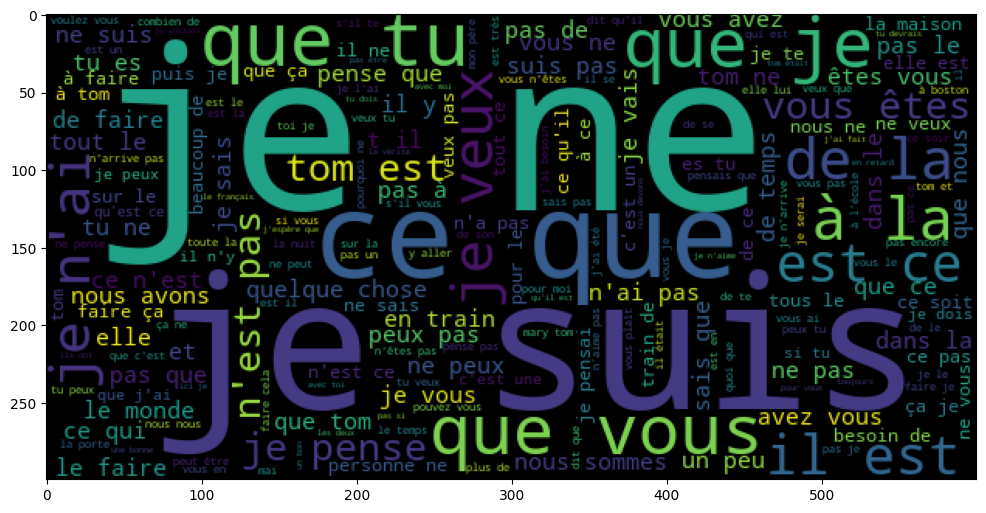

In [11]:
# The word cloud visualization of french words

plt.figure(figsize=(12, 8))
wc = WordCloud(width=600, height=300).generate(' '.join(fr_sentences))
plt.imshow(wc)
plt.show()

In [12]:
# Count the words on each sentence on the dataset
from functions import word_count
df['English_word_count'] = df['English words/sentences'].apply(lambda x: word_count(x))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: word_count(x))

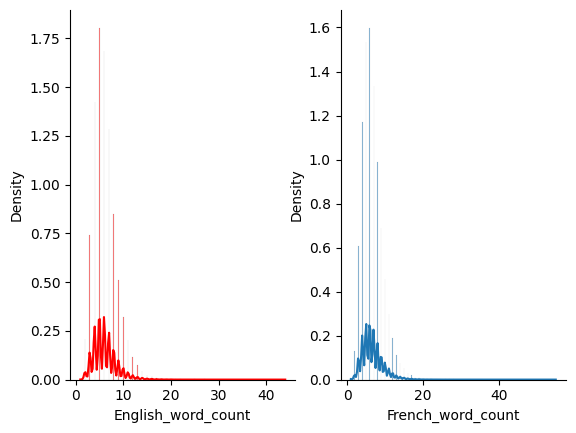

In [13]:
# Visualize the density of words on each sentence of both english and french datasets
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2)
sns.histplot(df['English_word_count'], kde=True, stat="density", color='red', ax=axes[0])
sns.histplot(df['French_word_count'], kde=True, stat="density", ax=axes[1])
sns.despine()
plt.show()

In [14]:
# Adding <start> at the beginning and <end> at the end of each target sentence (French sentences)
fr_sentences =  ["<start> " + sentence.strip() + " <end>" for sentence in fr_sentences]

In [15]:
fr_sentences[:3]

['<start> salut! <end>', '<start> cours! <end>', '<start> courez! <end>']

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from functions import max_sentence_length

# Prepare the english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(eng_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = max_sentence_length(eng_sentences)

# Prepare the french tokenizer
fr_tokenizer = Tokenizer(filters='')
fr_tokenizer.fit_on_texts(fr_sentences)
fr_vocab_size = len(fr_tokenizer.word_index) + 1
max_fr_sent_len = max_sentence_length(fr_sentences)

In [17]:
print("------------ English Sentences:")
print("Vocabulary size:", eng_vocab_size)
print("Maximum length:", max_eng_sent_len)
print("------------ French Sentences:")
print("Vocabulary size:", fr_vocab_size)
print("Maximum length:", max_fr_sent_len)

------------ English Sentences:
Vocabulary size: 14532
Maximum length: 44
------------ French Sentences:
Vocabulary size: 46161
Maximum length: 57


In [18]:
# Setting the max length of english and french sentences parameters
max_eng_sent_len = 20
max_fr_sent_len = 20

In [19]:
# Perform encoding of sequences
from functions import encode_sequences
X = encode_sequences(eng_tokenizer, eng_sentences, max_eng_sent_len)
y = encode_sequences(fr_tokenizer, fr_sentences, max_fr_sent_len)

In [20]:
# Split the dataset into training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=101)

In [21]:
# Split y_train into decoder input and target output
y_train_input = y_train[:, :-1]      # decoder input
y_train_output = y_train[:, 1:]      # decoder target

# Split y_test into decoder input and target output
y_test_input = y_test[:, :-1]
y_test_output = y_test[:, 1:]

# **Build and Train the Seq2Seq Model with Attention Mechanism :**

In [22]:
### Build and Train the Model :

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention

In [24]:
# Parameters
embedding_dim = 256
lstm_units = 512

In [25]:
# Encoder
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
enc_emb = Embedding(input_dim=eng_vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [26]:
# Decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb = Embedding(input_dim=fr_vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
# Attention Mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])
# Concatenate attention output with decoder outputs
decoder_combined_context = Concatenate()([attention_output, decoder_outputs])
# Output layer
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

In [27]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, mode='max', verbose=1, factor=0.2, min_lr=1e-15)

In [ ]:
# Train the model
history = model.fit([X_train, y_train_input],     # input sequences: encoder + decoder
                    y_train_output,               # expected output sequence
                    epochs=15,
                    batch_size=32,
                    validation_data=([X_test, y_test_input], y_test_output),
                    callbacks=[es, lr]
)

In [ ]:
model.save('Attention_Translator.keras')

In [ ]:
### Load and Use the Attention Model for Translation:

In [30]:
from tensorflow.keras.models import load_model

attention_model = load_model('Attention_Translator.keras')

In [31]:
# Translate a random sentence from the dataset
import numpy as np
from functions import translate

index = np.random.randint(len(eng_sentences))
eng_sentence = eng_sentences[index].capitalize()
fr_sentence = fr_sentences[index].replace('<start> ', '').replace(' <end>', '').capitalize()
print("Original English Sentence :", eng_sentence)
print("Original French Sentence :", fr_sentence)
print("Translated sentence :", translate(eng_sentence, eng_tokenizer, fr_tokenizer, attention_model, max_eng_sent_len, max_fr_sent_len).capitalize())

Original English Sentence : Has something happened?
Original French Sentence : Est-il arrivé quelque chose?
Translated sentence : Est-ce que quelque chose est arrivé?


In [32]:
# Function to translate a sentence from English to French
from functions import translate

def translate_sentence(sentence):
    translation = translate(sentence, eng_tokenizer, fr_tokenizer, attention_model, max_eng_sent_len, max_fr_sent_len)
    return translation.capitalize()

In [33]:
translate_sentence('Good Luck!')

'Bonne chance!'